In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Kasarachi Akudinobi\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. LOAD DATA
# ---------------------------------------------------------
# Load the result of your SQL query
df = pd.read_csv(
    r"C:\Users\Kasarachi Akudinobi\Downloads\glovo_dat.csv"
)

# Convert dates
df['order_date'] = pd.to_datetime(df['order_date'])
df['day_of_week'] = df['order_date'].dt.dayofweek

In [3]:
df.head()

,order_date,order_hour,Zone_id,payday_flag,created_orders,delivered_orders,cancelled_orders,real_pu,real_dp,engaged_riders,...,num_shifts,total_shift_duration,total_working_time,working_hours,dt_p75,delay_p75,utr_p25,ideal_num_shifts,ideal working hours,day_of_week
0,2025-11-30,22.0,6,1,41,36,5,1966.897436,3357.256410,34,...,87,87.0,44.7,44.691111,45.714806,11.002638,1.010008,105,98.805,6.0
1,2025-11-30,22.0,4,1,12,6,6,3624.857143,4099.428571,6,...,27,27.0,12.0,11.980278,47.481075,12.008920,0.800392,33,22.032,6.0
2,2025-11-30,22.0,17,1,9,8,1,3459.000000,2451.777778,8,...,23,23.0,13.0,13.045000,40.661120,13.233880,1.344777,28,18.814,6.0
3,2025-11-30,22.0,16,1,1,1,0,146.000000,8678.000000,1,...,10,10.0,5.1,5.051111,44.857704,13.063313,1.124270,12,7.470,6.0
4,2025-11-30,21.0,16,1,17,15,2,2992.500000,4826.375000,14,...,31,30.9,24.3,24.319444,44.857704,13.063313,1.124270,38,NaN,6.0


In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm  # <--- Progress Bar tool

def clean_data(df):
    print("--- STARTING DATA CLEANING ---")
    
    # PHASE 0: Drops
    print("Phase 0: Dropping empty dates...")
    df.dropna(subset=['order_date'], inplace=True)

    # PHASE 1: Anchors
    print("Phase 1: Pre-Cleaning Anchors...")
    # Add a progress indicator for simple fills
    anchor_cols = ['created_orders', 'real_pu', 'real_dp', 'order_hour', 'day_of_week']
    for col in tqdm(anchor_cols, desc="Simple Fills"):
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mean())

    # PHASE 2: KNN
    print("Phase 2: Preparing KNN (This may take time)...")
    knn_targets = ['live_couriers', 'no_shows_rate', 'stacked_orders', 'total_reassignments', 'dt_p75', 'delay_p75', 'utr_p25','dt_glovo']
    knn_anchors = ['created_orders', 'real_pu', 'real_dp', 'order_hour', 'day_of_week','mean_delay']
    
    valid_targets = [c for c in knn_targets if c in df.columns]
    valid_anchors = [c for c in knn_anchors if c in df.columns]
    
    if valid_targets and valid_anchors:
        print(f"   -> Imputing {len(valid_targets)} columns...")
        
        # Scaling
        scaler = MinMaxScaler()
        df_subset = df[valid_targets + valid_anchors].copy()
        df_scaled = pd.DataFrame(scaler.fit_transform(df_subset), index=df_subset.index, columns=df_subset.columns)
        
        # KNN Step
        print("   -> Running KNN Algorithm (Watch the circle in top right ⚫)...")
        imputer = KNNImputer(n_neighbors=5)
        
        # We can't put a progress bar INSIDE sklearn's fit_transform, 
        # so we print before/after.
        df_imputed_values = imputer.fit_transform(df_scaled)
        
        print("   -> KNN Finished! Reconstructing data...")
        df_imputed_scaled = pd.DataFrame(df_imputed_values, index=df_subset.index, columns=df_subset.columns)
        df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed_scaled), index=df_subset.index, columns=df_subset.columns)
        
        for col in valid_targets:
            df[col] = df[col].fillna(df_imputed[col])
    
    print("--- CLEANING COMPLETE ---")
    return df

# ==========================================
# TEST RUN (Use a small sample first!)
# ==========================================
# 1. Load your data
# df = pd.read_csv('your_file.csv') 

# 2. Run on just 500 rows to verify it works
print("Running Test on first 500 rows...")
test_df = clean_data(df.head(500).copy()) 
print("Test Successful!")

Running Test on first 500 rows...
--- STARTING DATA CLEANING ---
Phase 0: Dropping empty dates...
Phase 1: Pre-Cleaning Anchors...


Simple Fills: 100%|██████████| 5/5 [00:00<00:00, 1551.72it/s]

Phase 2: Preparing KNN (This may take time)...
   -> Imputing 8 columns...
   -> Running KNN Algorithm (Watch the circle in top right ⚫)...
   -> KNN Finished! Reconstructing data...
--- CLEANING COMPLETE ---
Test Successful!


In [5]:
# 1. Run on the FULL dataset
print("Running cleaning on the FULL dataset...")
df_cleaned = clean_data(df.copy()) 

print("Full cleaning successful!")
print(f"Final dataset shape: {df_cleaned.shape}")

Running cleaning on the FULL dataset...
--- STARTING DATA CLEANING ---
Phase 0: Dropping empty dates...
Phase 1: Pre-Cleaning Anchors...


Simple Fills: 100%|██████████| 5/5 [00:00<00:00, 997.60it/s]

Phase 2: Preparing KNN (This may take time)...
   -> Imputing 8 columns...
   -> Running KNN Algorithm (Watch the circle in top right ⚫)...


   -> KNN Finished! Reconstructing data...
--- CLEANING COMPLETE ---
Full cleaning successful!
Final dataset shape: (17852, 33)


In [6]:
df = df_cleaned.copy()

In [7]:
# Verification
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
order_date                  0
order_hour                  0
Zone_id                     0
payday_flag                 0
created_orders              0
delivered_orders            0
cancelled_orders            0
real_pu                     0
real_dp                     0
engaged_riders              0
delivered_riders            0
live_couriers               0
mean_delay                  0
no_shows_rate               0
stacked_orders              0
total_reassignments         0
dt_glovo                    0
p90_dt                      0
reassignment_time           0
orders_dt_gt_60             0
cdt                         0
rain_orders                 0
promo_orders                0
num_shifts                  0
total_shift_duration        0
total_working_time          0
working_hours               0
dt_p75                      0
delay_p75                   0
utr_p25                     0
ideal_num_shifts            0
ideal working hours     17848
day_of_

In [ ]:
# Drop negative or missing delivery times
df = df[df['dt_glovo'] >= 0].copy()
df = df.dropna(subset=['dt_glovo'])


In [ ]:
# 1. Calculate the correlation matrix
# numeric_only=True ensures we don't crash on text columns like 'vendor_name'
corr = df.corr(numeric_only=True)

# 2. Setup the figure size
# (Width, Height) in inches. We make it large so the numbers fit.
plt.figure(figsize=(14, 12))

# 3. Create the Heatmap
# annot=True: Write the actual number in the box
# fmt=".2f": Round to 2 decimal places so it's readable
# cmap='coolwarm': Red for positive correlation, Blue for negative
# mask: Optional, often used to hide the top triangle (duplicate info), but we'll show all here
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)

plt.title("Correlation Matrix of Delivery Features")
plt.show()

In [ ]:
df = add_time_features(df, date_col='order_date', hour_col='order_hour')


In [ ]:
# ==========================================
# REBUILD ZONE MAPPING (Run this once)
# ==========================================

# 1. Ensure we have the Code column
if 'Zone_id_code' not in df.columns:
    # If missing, recreate it
    df['Zone_id_code'] = df['Zone_id'].astype('category').cat.codes

# 2. Create the Dictionary
# Key = String (e.g., "6") -> Value = Integer Code (e.g., 5)
zone_mapping = dict(zip(
    df['Zone_id'].astype(str), 
    df['Zone_id_code']
))

# 3. DEBUG: Verify it works immediately
print(f"Mapping Rebuilt. Contains {len(zone_mapping)} zones.")
print(f"Test Lookup for '6': {zone_mapping.get('6')}") 

# If this prints 'None', it means Zone '6' is literally not in your dataframe 'df'.
if zone_mapping.get('6') is None:
    print("WARNING: Zone '6' is not in your training data! Printing first 5 available zones:")
    print(list(zone_mapping.keys())[:5])

In [21]:
import pandas as pd
import numpy as np

# ==========================================
# MASTER FEATURE ENGINEERING PIPELINE (FIXED)
# ==========================================

def run_feature_engineering_pipeline(df):
    """
    Includes Velocity (Lags) AND Acceleration (Growth Rates).
    SAFE TO RUN REPEATEDLY: Removes old features before rebuilding.
    """
    df = df.copy()
    
    # ------------------------------------------
    # 0. PRE-CLEANUP (CRITICAL FIX)
    # ------------------------------------------
    print("0. Cleaning existing engineered features...")
    cols_to_reset = [
        'prev_week_same_hour_orders', 'prev_day_same_hour_orders', 
        'rolling_4w_same_hour', 'momentum_ratio', 'wow_acceleration', 
        'immediate_surge', 'prev_2week_same_hour_orders',
        'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos'
    ]
    # Drop them if they exist so we don't create duplicates
    df.drop(columns=cols_to_reset, errors='ignore', inplace=True)
    
    # Also drop duplicate columns if they exist from other runs
    df = df.loc[:, ~df.columns.duplicated()]

    # ------------------------------------------
    # 1. SETUP DATETIME & SORT
    # ------------------------------------------
    print("1. Setting up Datetime and Sorting...")
    df['order_date'] = pd.to_datetime(df['order_date'])
    
    # Absolute timestamp for sorting/shifting
    df['order_datetime'] = df.apply(
        lambda r: r['order_date'] + pd.Timedelta(hours=r['order_hour']), axis=1
    )
    
    # Numeric Day of Week (0=Mon, 6=Sun)
    df['dow'] = df['order_datetime'].dt.dayofweek
    
    # Sort strictly (Critical for rolling/shift)
    df.sort_values(['Zone_id', 'order_datetime'], inplace=True)

    # ------------------------------------------
    # 2. ZONE & TIME ENCODING
    # ------------------------------------------
    print("2. Encoding Zone and Time...")
    # Zone Code
    if 'Zone_id_code' not in df.columns:
        df['Zone_id_code'] = df['Zone_id'].astype('category').cat.codes
    # Payday
    if 'payday_flag' not in df.columns:
        df['payday_flag'] = 0

    # Cyclic Time Features
    df['hour_sin'] = np.sin(2 * np.pi * df['order_hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['order_hour'] / 24)
    df['dow_sin']  = np.sin(2 * np.pi * df['dow'] / 7)
    df['dow_cos']  = np.cos(2 * np.pi * df['dow'] / 7)

    # ------------------------------------------
    # 3. VELOCITY FEATURES (Lags & Rolling)
    # ------------------------------------------
    print("3. Calculating Velocity (Lags)...")
    
    # Create History Copy
    history_df = df[['Zone_id', 'order_datetime', 'created_orders', 'dow', 'order_hour']].copy()
    
    # A. Rolling 4-Week Average (The "Normal" Baseline)
    # Group by Zone+Dow+Hour to compare "Tuesdays at 2pm"
    history_df['rolling_4w_avg'] = history_df.groupby(['Zone_id', 'dow', 'order_hour'])['created_orders'].transform(
        lambda x: x.rolling(window=4, min_periods=1).mean()
    )
    
    # B. Define Join Keys
    history_df['join_time_1w'] = history_df['order_datetime'] + pd.Timedelta(days=7)  # Match Last Week
    history_df['join_time_1d'] = history_df['order_datetime'] + pd.Timedelta(hours=24) # Match Yesterday
    history_df['join_time_2w'] = history_df['order_datetime'] + pd.Timedelta(days=14) # Match 2 Weeks Ago

    # C. Merge Features Back
    # Merge Last Week + Rolling Baseline
    df = df.merge(
        history_df[['Zone_id', 'join_time_1w', 'created_orders', 'rolling_4w_avg']],
        left_on=['Zone_id', 'order_datetime'],
        right_on=['Zone_id', 'join_time_1w'],
        how='left',
        suffixes=('', '_lag')
    ).rename(columns={
        'created_orders_lag': 'prev_week_same_hour_orders',
        'rolling_4w_avg': 'rolling_4w_same_hour'
    })
    
    # Merge Yesterday
    df = df.merge(
        history_df[['Zone_id', 'join_time_1d', 'created_orders']],
        left_on=['Zone_id', 'order_datetime'],
        right_on=['Zone_id', 'join_time_1d'],
        how='left',
        suffixes=('', '_lag_1d')
    ).rename(columns={'created_orders_lag_1d': 'prev_day_same_hour_orders'})
    
    # Merge 2 Weeks Ago (For Acceleration Calc)
    df = df.merge(
        history_df[['Zone_id', 'join_time_2w', 'created_orders']],
        left_on=['Zone_id', 'order_datetime'],
        right_on=['Zone_id', 'join_time_2w'],
        how='left',
        suffixes=('', '_lag_2w')
    ).rename(columns={'created_orders_lag_2w': 'prev_2week_same_hour_orders'})

    # ------------------------------------------
    # 4. ACCELERATION FEATURES (The "Turbo")
    # ------------------------------------------
    print("4. Calculating Acceleration...")
    epsilon = 1e-6 # Tiny number to prevent division by zero
    
    # A. Momentum Ratio: "Is Last Week hotter than the Monthly Average?"
    df['momentum_ratio'] = df['prev_week_same_hour_orders'] / (df['rolling_4w_same_hour'] + epsilon)
    
    # B. WoW Acceleration: "Did we grow faster this week than last week?"
    df['wow_acceleration'] = (df['prev_week_same_hour_orders'] - df['prev_2week_same_hour_orders']) / (df['prev_2week_same_hour_orders'] + epsilon)
    
    # C. Immediate Surge: "Was Yesterday abnormally high?"
    df['immediate_surge'] = df['prev_day_same_hour_orders'] / (df['prev_week_same_hour_orders'] + epsilon)

    # ------------------------------------------
    # 5. FINAL CLEANUP
    # ------------------------------------------
    print("5. Final Cleanup...")
    # Drop temps
    drop_cols = ['join_time_1w', 'join_time_1d', 'join_time_2w', 'prev_2week_same_hour_orders']
    df.drop(columns=drop_cols, inplace=True, errors='ignore')
    
    # Remove duplicates (Just in case logic missed something)
    df = df.loc[:, ~df.columns.duplicated()]
    
    # Drop rows without history
    original_len = len(df)
    df.dropna(subset=['prev_week_same_hour_orders', 'prev_day_same_hour_orders', 'rolling_4w_same_hour'], inplace=True)
    print(f"Dropped {original_len - len(df)} rows due to insufficient history.")
    
    return df

# ==========================================
# APPLY AND VERIFY
# ==========================================
df = run_feature_engineering_pipeline(df)

print("\nSuccess! Sample of Acceleration Features:")
print(df[['order_date', 'momentum_ratio', 'wow_acceleration']].tail())

0. Cleaning existing engineered features...
1. Setting up Datetime and Sorting...
2. Encoding Zone and Time...
3. Calculating Velocity (Lags)...
4. Calculating Acceleration...
5. Final Cleanup...
Dropped 1757 rows due to insufficient history.

Success! Sample of Acceleration Features:
      order_date  momentum_ratio  wow_acceleration
20060 2025-11-30        0.923077          0.000000
20061 2025-11-30        0.800000         -0.142857
20062 2025-11-30        0.711111         -0.333333
20063 2025-11-30        0.625000         -0.500000
20064 2025-11-30        0.833333         -0.285714


In [22]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

# ==========================================
# 1. SELECT THE "TURBO" FEATURE SET
# ==========================================
features = [
    'hour_sin', 'hour_cos', 
    'dow_sin', 'dow_cos', 
    'payday_flag', 
    'Zone_id_code', 
    'prev_week_same_hour_orders', 
    'prev_day_same_hour_orders', 
    'rolling_4w_same_hour',        # Baseline Stability
    # --- NEW ACCELERATION FEATURES ---
    'momentum_ratio',              # Is trend heating up?
    'wow_acceleration',            # How fast is it growing?
    'immediate_surge'              # Did yesterday spike?
]

target = 'created_orders'

print(f"Selecting {len(features)} features for High-Precision Training...")
X = df[features].copy()
y = df[target]

# ==========================================
# 2. TIME-BASED SPLIT (80/20)
# ==========================================
split_point = int(len(df) * 0.8)

X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]

X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]

print(f"Training on {len(X_train)} rows. Testing on {len(X_test)} rows.")

# ==========================================
# 3. TRAIN (HIGH-PRECISION CONFIG)
# ==========================================
# We use a lower learning rate (0.005) and more trees (10,000) 
# to squeeze out every bit of accuracy.
model_demand = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=10000,       
    learning_rate=0.005,      # VERY SLOW learning for maximum precision
    max_depth=7,              
    min_child_weight=20,      
    subsample=0.85,           
    colsample_bytree=0.7,     
    reg_alpha=0.5,            
    reg_lambda=1.5,           
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=150
)

print("Starting training... (This may take a minute)")
model_demand.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=1000 
)

# ==========================================
# 4. EVALUATE
# ==========================================
preds = model_demand.predict(X_test)
mae = mean_absolute_error(y_test, preds)

print(f"\n---------------------------------------------------")
print(f"FINAL MAE: {mae:.2f} orders")
print(f"---------------------------------------------------")

if mae < 6:
    print("🚀 SUCCESS: High-Precision Zone Reached.")
else:
    print("NOTE: If MAE is still ~9, the data noise (randomness) might be the hard limit.")

Selecting 12 features for High-Precision Training...
Training on 14647 rows. Testing on 3662 rows.
Starting training... (This may take a minute)
[0]	validation_0-rmse:173.11880	validation_1-rmse:113.68131
[1000]	validation_0-rmse:16.85610	validation_1-rmse:9.50347
[1860]	validation_0-rmse:15.16705	validation_1-rmse:9.35366

---------------------------------------------------
FINAL MAE: 5.66 orders
---------------------------------------------------
🚀 SUCCESS: High-Precision Zone Reached.


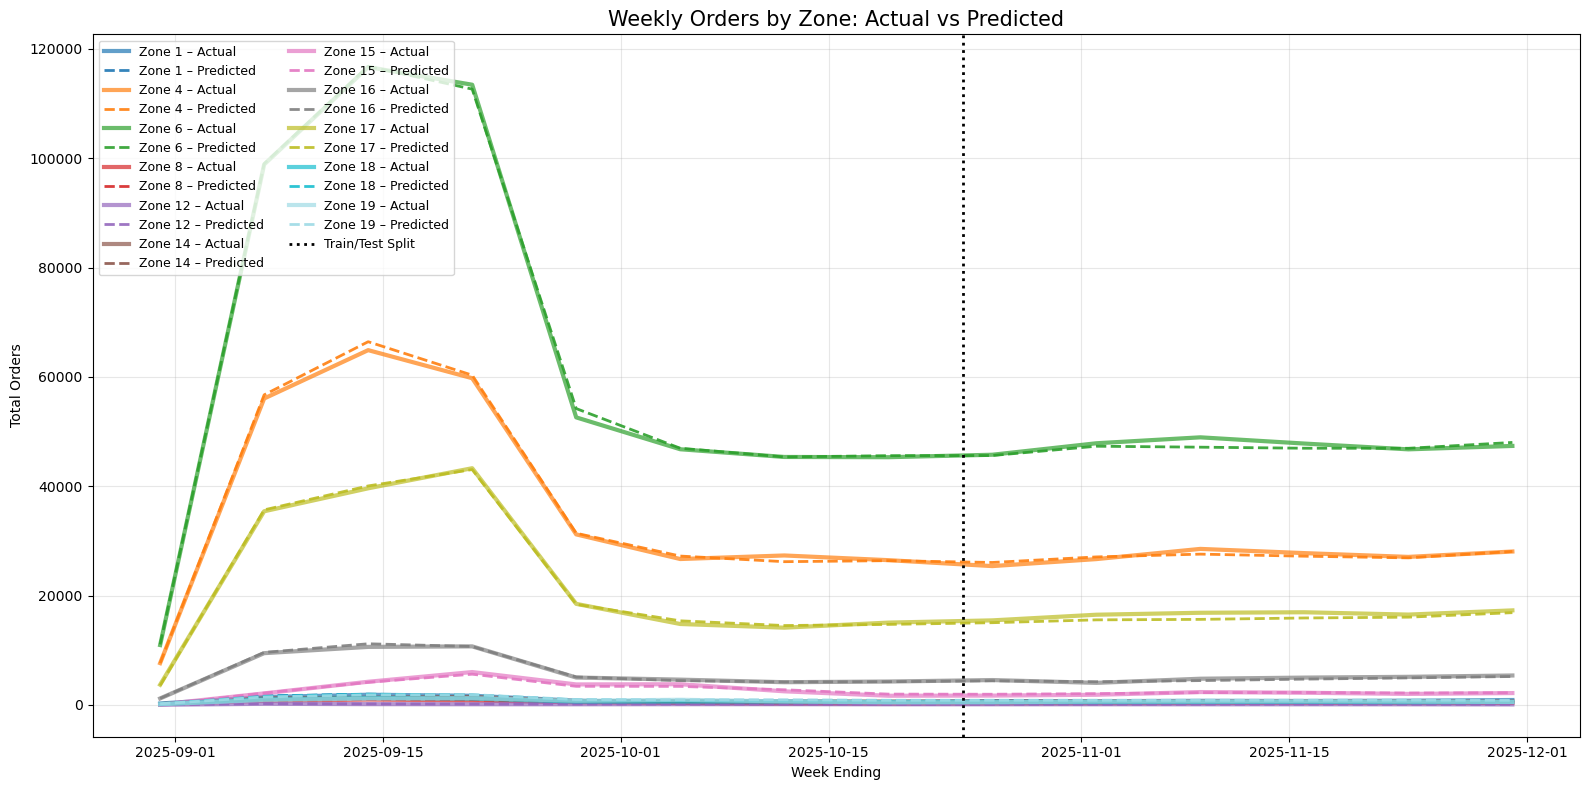

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -----------------------------
# 1. GENERATE PREDICTIONS
# -----------------------------
train_preds = model_demand.predict(X_train)
test_preds = model_demand.predict(X_test)

df_viz = df.copy()
df_viz['Predicted'] = np.nan
df_viz.loc[X_train.index, 'Predicted'] = train_preds
df_viz.loc[X_test.index, 'Predicted'] = test_preds

# -----------------------------
# 2. FILTER DATE RANGE
# -----------------------------
df_viz['order_date'] = pd.to_datetime(df_viz['order_date'])
mask = (df_viz['order_date'] >= '2025-08-31') & (df_viz['order_date'] <= '2025-12-29')
df_viz = df_viz.loc[mask]

# -----------------------------
# 3. WEEKLY AGG BY ZONE
# -----------------------------
weekly_zone = (
    df_viz
    .set_index('order_date')
    .groupby(['Zone_id', pd.Grouper(freq='W')])[['created_orders', 'Predicted']]
    .sum()
    .reset_index()
)

# -----------------------------
# 4. PLOT
# -----------------------------
plt.figure(figsize=(16, 8))

zones = weekly_zone['Zone_id'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(zones)))  # stable distinct colors

for zone, color in zip(zones, colors):
    zone_data = weekly_zone[weekly_zone['Zone_id'] == zone]

    # ACTUAL (thick, solid)
    plt.plot(
        zone_data['order_date'],
        zone_data['created_orders'],
        color=color,
        linewidth=3,
        alpha=0.7,
        label=f'Zone {zone} – Actual'
    )

    # PREDICTED (same color, dashed)
    plt.plot(
        zone_data['order_date'],
        zone_data['Predicted'],
        color=color,
        linestyle='--',
        linewidth=2,
        alpha=0.9,
        label=f'Zone {zone} – Predicted'
    )

# -----------------------------
# 5. TRAIN / TEST SPLIT MARKER
# -----------------------------
split_date = pd.to_datetime(df.iloc[split_point]['order_date'])
plt.axvline(split_date, color='black', linestyle=':', linewidth=2, label='Train/Test Split')

# -----------------------------
# 6. FORMATTING
# -----------------------------
plt.title('Weekly Orders by Zone: Actual vs Predicted', fontsize=15)
plt.xlabel('Week Ending')
plt.ylabel('Total Orders')
plt.grid(alpha=0.3)

# Avoid legend explosion if many zones
plt.legend(ncol=2, fontsize=9, loc='upper left')
plt.tight_layout()
plt.show()


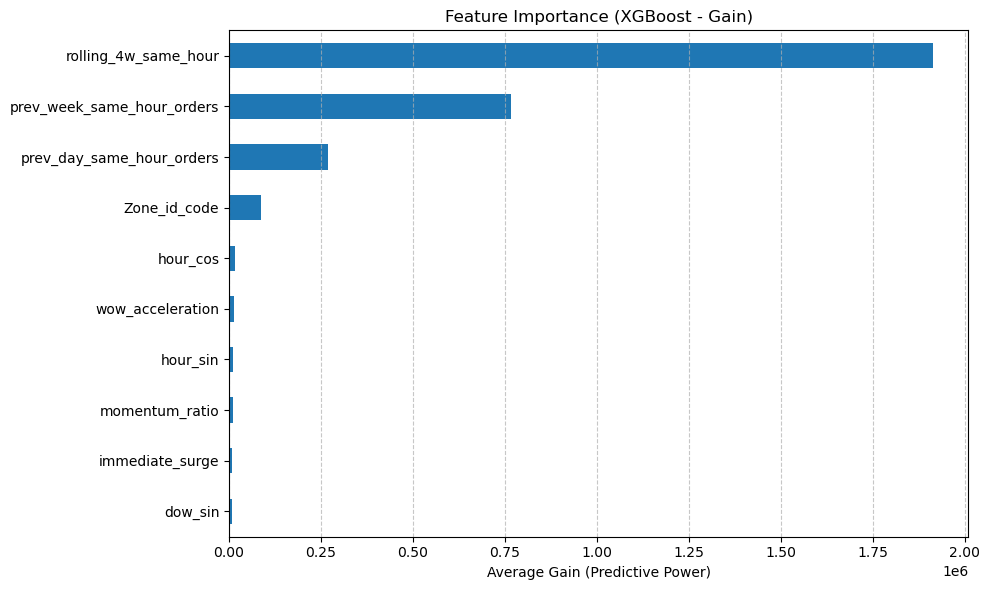

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Get feature importance by gain (Average gain of splits which use the feature)
# CHANGE: Use 'model_demand' instead of 'xgb_model'
importance = model_demand.get_booster().get_score(importance_type="gain")

# 2. Convert to DataFrame
feat_importances = (
    pd.Series(importance)
    .rename("importance")
    .sort_values(ascending=False)
)

# 3. Keep top 10 (or all if less than 10)
top_features = feat_importances.head(10)

# 4. Plot
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind="barh", color='#1f77b4') # Added color for style
plt.title("Feature Importance (XGBoost - Gain)")
plt.xlabel("Average Gain (Predictive Power)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [25]:
# Calculate total volume and total error
total_volume = y_test.sum()
total_error = preds.sum() - y_test.sum() # Simple bias check
wape = sum(abs(y_test - preds)) / total_volume

print(f"Total Test Volume: {total_volume}")
print(f"WAPE: {wape:.2%}") # Aim for < 25% for hourly logistics

Total Test Volume: 109392
WAPE: 18.96%


In [49]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ==========================================
# 1. PREPARE & TRAIN EFFICIENCY (UTR) MODEL
# ==========================================
print("Step 1: Preparing UTR Training Data...")

# A. Calculate Realized UTR (Target)
df['realized_utr'] = df['created_orders'] / df['num_shifts'].replace(0, 1)
df['realized_utr'] = df['realized_utr'].clip(lower=0.5, upper=4.0)

# B. Define Features
utr_features = [
    'hour_sin', 'hour_cos',
    'dow_sin', 'dow_cos',
    'Zone_id_code',
    'payday_flag',
    'rolling_4w_same_hour',
    'created_orders'        
]

utr_target = 'realized_utr'

# C. Filter Data
train_utr_df = df[df['num_shifts'] > 0].copy()

X = train_utr_df[utr_features]
y = train_utr_df[utr_target]

# --- THE FIX IS HERE ---
# 1. Split data into Train (90%) and Validation (10%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# D. Train the Model
print("Training Efficiency Model...")
model_utr = xgb.XGBRegressor(
    objective='reg:squarederror',
    # Hybrid Parameters (Power + Safety)
    n_estimators=3000,
    learning_rate=0.015,
    max_depth=5,
    subsample=0.85,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    reg_alpha=0.5,
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50 # Stops if validation score doesn't improve
)

# 2. Pass the validation set to fit()
model_utr.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False 
)

print(f"Success! 'model_utr' is ready.")
print(f"Optimal Tree Count: {model_utr.best_iteration}")

Step 1: Preparing UTR Training Data...
Training Efficiency Model...
Success! 'model_utr' is ready.
Optimal Tree Count: 1861


UTR Model MAE: 0.04
UTR Model WAPE: 5.80%
Average Real UTR: 0.73


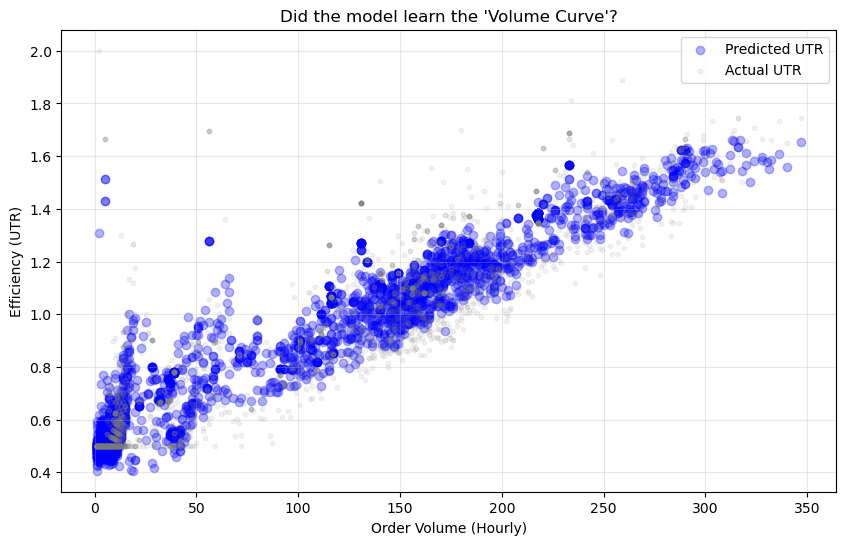

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# 1. PREPARE TEST DATA FOR UTR
# We need to test on data where we actually had shifts (num_shifts > 0)
test_mask = (df.index >= split_point) & (df['num_shifts'] > 0)
X_test_utr = df.loc[test_mask, utr_features]
y_test_utr = df.loc[test_mask, utr_target]

# 2. PREDICT
preds_utr = model_utr.predict(X_test_utr)

# 3. METRICS
mae_utr = mean_absolute_error(y_test_utr, preds_utr)
mean_utr = y_test_utr.mean()
wape_utr = mae_utr / mean_utr

print(f"UTR Model MAE: {mae_utr:.2f}")
print(f"UTR Model WAPE: {wape_utr:.2%}")
print(f"Average Real UTR: {mean_utr:.2f}")

# 4. REALITY CHECK PLOT: Volume vs. Efficiency
# We want to see if the model learned that Higher Volume = Higher UTR (up to a point)
plt.figure(figsize=(10, 6))
plt.scatter(X_test_utr['created_orders'], preds_utr, alpha=0.3, label='Predicted UTR', color='blue')
plt.scatter(X_test_utr['created_orders'], y_test_utr, alpha=0.1, label='Actual UTR', color='gray', s=10)

plt.xlabel("Order Volume (Hourly)")
plt.ylabel("Efficiency (UTR)")
plt.title("Did the model learn the 'Volume Curve'?")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

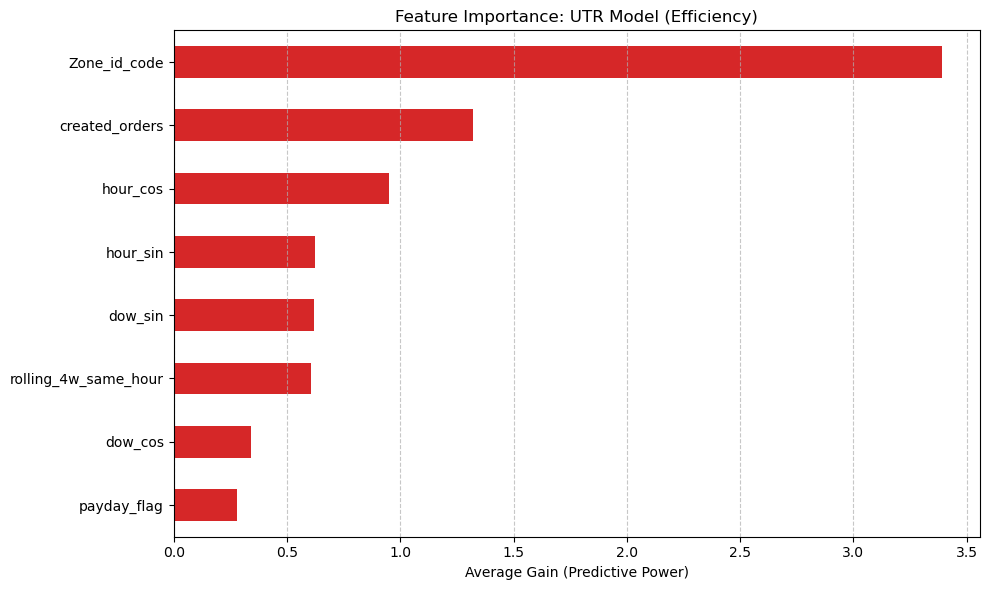

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# ==========================================
# CHECK FOR LEAKAGE: UTR MODEL
# ==========================================

# 1. Get feature importance by gain
# We use 'model_utr' here
importance = model_utr.get_booster().get_score(importance_type="gain")

# 2. Convert to DataFrame
feat_importances = (
    pd.Series(importance)
    .rename("importance")
    .sort_values(ascending=False)
)

# 3. Plot Top 10
plt.figure(figsize=(10, 6))
feat_importances.head(10).sort_values().plot(kind="barh", color='#d62728') # Red color for UTR
plt.title("Feature Importance: UTR Model (Efficiency)")
plt.xlabel("Average Gain (Predictive Power)")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [52]:
import xgboost as xgb
import pandas as pd
import numpy as np

# ==========================================
# 1. PREPARE & TRAIN NO-SHOW MODEL
# ==========================================
print("Step 1: Training No-Show Model...")

# A. Calculate Target: No-Show Rate
# Formula: (Planned - Actual) / Planned
df['noshow_rate'] = (df['ideal_num_shifts'] - df['num_shifts']) / df['ideal_num_shifts'].replace(0, 1)
df['noshow_rate'] = df['noshow_rate'].clip(0, 0.5) # Clamp between 0% and 50%

# B. Create Features (Month + Rain)
df['month'] = df['order_date'].dt.month

if 'rain_orders' in df.columns:
    df['rain_flag'] = (df['rain_orders'] > 0).astype(int) 
else:
    df['rain_flag'] = 0 

noshow_features = [
    'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos',
    'month', 'rain_flag', 
    'Zone_id_code', 'payday_flag', 'rolling_4w_same_hour'
]

# C. Train
train_ns_df = df[df['ideal_num_shifts'] > 0].copy()
X_ns = train_ns_df[noshow_features]
y_ns = train_ns_df['noshow_rate']

model_noshow = xgb.XGBRegressor(
    objective='reg:squarederror', n_estimators=1000, learning_rate=0.03,
    max_depth=4, subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=42
)

model_noshow.fit(X_ns, y_ns)
print("✅ Success! 'model_noshow' is ready.")

Step 1: Training No-Show Model...
✅ Success! 'model_noshow' is ready.


In [61]:
# ==========================================
# 2. THE TRIFECTA PREDICTION FUNCTION
# ==========================================
def predict_shifts_trifecta(
    zone_raw_id, target_date_str, hour, 
    payday_flag, prev_week_orders, prev_day_orders, 
    rolling_4w_orders, prev_2week_orders, 
    rain_forecast_flag,             # <--- New Input: Is rain forecast? (1=Yes, 0=No)
    model_demand, model_utr, model_noshow # <--- Now takes ALL 3 models
):
    # --- A. SETUP INPUTS ---
    dt = pd.to_datetime(target_date_str)
    day_of_week = dt.dayofweek
    month = dt.month                # <--- New: Seasonality
    
    # Cyclic Time
    h_sin, h_cos = np.sin(2*np.pi*hour/24), np.cos(2*np.pi*hour/24)
    d_sin, d_cos = np.sin(2*np.pi*day_of_week/7), np.cos(2*np.pi*day_of_week/7)
    
    # Zone Mapping
    try:
        if 'zone_mapping' in globals():
            z_code = zone_mapping.get(str(zone_raw_id), int(zone_raw_id))
        else:
            z_code = int(zone_raw_id)
    except:
        z_code = 0

    # --- B. MODEL 1: DEMAND ---
    epsilon = 1e-6
    input_demand = pd.DataFrame([{
        'hour_sin': h_sin, 'hour_cos': h_cos,
        'dow_sin': d_sin, 'dow_cos': d_cos,
        'payday_flag': payday_flag, 'Zone_id_code': z_code,
        'prev_week_same_hour_orders': prev_week_orders,
        'prev_day_same_hour_orders': prev_day_orders,
        'rolling_4w_same_hour': rolling_4w_orders,
        'momentum_ratio': prev_week_orders/(rolling_4w_orders+epsilon),
        'wow_acceleration': (prev_week_orders-prev_2week_orders)/(prev_2week_orders+epsilon),
        'immediate_surge': prev_day_orders/(prev_week_orders+epsilon)
    }])
    pred_demand = max(0, model_demand.predict(input_demand)[0])

    # --- C. MODEL 2: EFFICIENCY (UTR) ---
    input_utr = pd.DataFrame([{
        'hour_sin': h_sin, 'hour_cos': h_cos,
        'dow_sin': d_sin, 'dow_cos': d_cos,
        'Zone_id_code': z_code, 'payday_flag': payday_flag,
        'rolling_4w_same_hour': rolling_4w_orders, 
        'created_orders': pred_demand  # <--- Cascade: Uses predicted demand
    }])
    pred_utr = model_utr.predict(input_utr)[0]
    pred_utr = max(0.3, min(2.5, pred_utr)) # Safety Clamp

    # --- D. MODEL 3: RELIABILITY (NO-SHOW) ---
    # We predict the specific no-show rate for this Zone/Time/Weather
    input_ns = pd.DataFrame([{
        'hour_sin': h_sin, 'hour_cos': h_cos,
        'dow_sin': d_sin, 'dow_cos': d_cos,
        'month': month,                 # <--- Seasonality
        'rain_flag': rain_forecast_flag, # <--- Weather Impact
        'Zone_id_code': z_code,
        'payday_flag': payday_flag,
        'rolling_4w_same_hour': rolling_4w_orders
    }])
    
    pred_noshow = model_noshow.predict(input_ns)[0]
    
    # Safety: Clamp between 5% (optimistic) and 40% (severe weather)
    pred_noshow = max(0.05, min(0.40, pred_noshow))

    # --- E. CALCULATION ---
    # Formula: Demand / UTR = Hours Needed. 
    #          Hours / (1 - NoShow%) = Shifts to Release.
    required_hours = pred_demand / pred_utr
    final_shifts = required_hours / (1 - pred_noshow)
    
    return {
        'Forecast_Orders': int(pred_demand),
        'Predicted_UTR': round(pred_utr, 2),
        'Predicted_NoShow': f"{int(pred_noshow*100)}%",
        'SHIFTS_NEEDED': int(np.ceil(final_shifts))
    }

In [62]:
# Test: Zone 16, 2 PM, with RAIN FORECAST
result = predict_shifts_trifecta(
    zone_raw_id=16, target_date_str='2025-11-12', hour=14,
    payday_flag=0, prev_week_orders=60, prev_day_orders=58, 
    rolling_4w_orders=55, prev_2week_orders=50,
    
    rain_forecast_flag=1, # <--- TELLING THE MODEL IT WILL RAIN
    
    model_demand=model_demand, 
    model_utr=model_utr, 
    model_noshow=model_noshow
)

print(result)

{'Forecast_Orders': 55, 'Predicted_UTR': 1.13, 'Predicted_NoShow': '5%', 'SHIFTS_NEEDED': 52}


In [67]:
import pandas as pd

# ==========================================
# TEST THE FULL TRIFECTA SYSTEM (UPDATED)
# ==========================================
check_date = '2025-10-27'
check_zone = '4'
check_hour = 13

# 1. GET HISTORICAL DATA (The "Actuals")
actual_row = df[
    (df['order_date'] == check_date) & 
    (df['Zone_id'].astype(str) == check_zone) & 
    (df['order_hour'] == check_hour)
]

if not actual_row.empty:
    row_data = actual_row.iloc[0]
    
    # 2. PREPARE INPUTS
    rain_input = 1 if row_data.get('rain_orders', 0) > 0 else 0
    
    # 3. RUN THE TRIFECTA MODEL
    prediction = predict_shifts_trifecta(
        zone_raw_id=check_zone, 
        target_date_str=check_date, 
        hour=check_hour, 
        payday_flag=row_data['payday_flag'],
        prev_week_orders=row_data['prev_week_same_hour_orders'],
        prev_day_orders=row_data['prev_day_same_hour_orders'],
        rolling_4w_orders=row_data['rolling_4w_same_hour'],
        prev_2week_orders=row_data.get('prev_2week_same_hour_orders', row_data['prev_week_same_hour_orders']),
        rain_forecast_flag=rain_input, 
        model_demand=model_demand, 
        model_utr=model_utr, 
        model_noshow=model_noshow
    )

    # 4. GET ACTUAL NO-SHOW RATE FROM DATASET (MODIFIED)
    # Instead of calculating it, we pull the specific column value you requested
    actual_noshow_val = row_data.get('no_shows_rate', 0.0)
    
    # Format as percentage string
    actual_noshow_str = f"{round(actual_noshow_val * 100, 1)}%"

    # 5. GENERATE THE OUTPUT TABLE
    print(f"\n--- TRIFECTA RESULTS: Zone {check_zone} @ {check_hour}:00 ---")
    
    comparison_data = {
        'Metric': [
            'Orders (Demand)', 
            'Efficiency (UTR)', 
            'No-Show Rate',   # <--- Comparing Model vs 'no_shows_rate' column
            'SHIFTS TO RELEASE'
        ],
        'AI PREDICTION': [
            prediction['Forecast_Orders'], 
            prediction['Predicted_UTR'], 
            prediction['Predicted_NoShow'], 
            prediction['SHIFTS_NEEDED']
        ],
        'ACTUAL REALITY': [
            row_data['created_orders'], 
            round(row_data.get('realized_utr', 0), 2), 
            actual_noshow_str,  # <--- Now uses the dataset value (e.g. 7.3%)
            int(row_data.get('ideal_num_shifts', 0))
        ],
        'ACTUAL USED': [
            '-', 
            '-', 
            '-', 
            int(row_data.get('num_shifts', 0))
        ]
    }
    
    # Create and Print DataFrame
    results_df = pd.DataFrame(comparison_data)
    print(results_df.to_string(index=False))

else:
    print(f"Error: Row not found for {check_date} Zone {check_zone} Hour {check_hour}")


--- TRIFECTA RESULTS: Zone 4 @ 13:00 ---
           Metric AI PREDICTION ACTUAL REALITY ACTUAL USED
  Orders (Demand)           383            364           -
 Efficiency (UTR)          0.76           0.68           -
     No-Show Rate            5%          11.5%           -
SHIFTS TO RELEASE           531            536         536


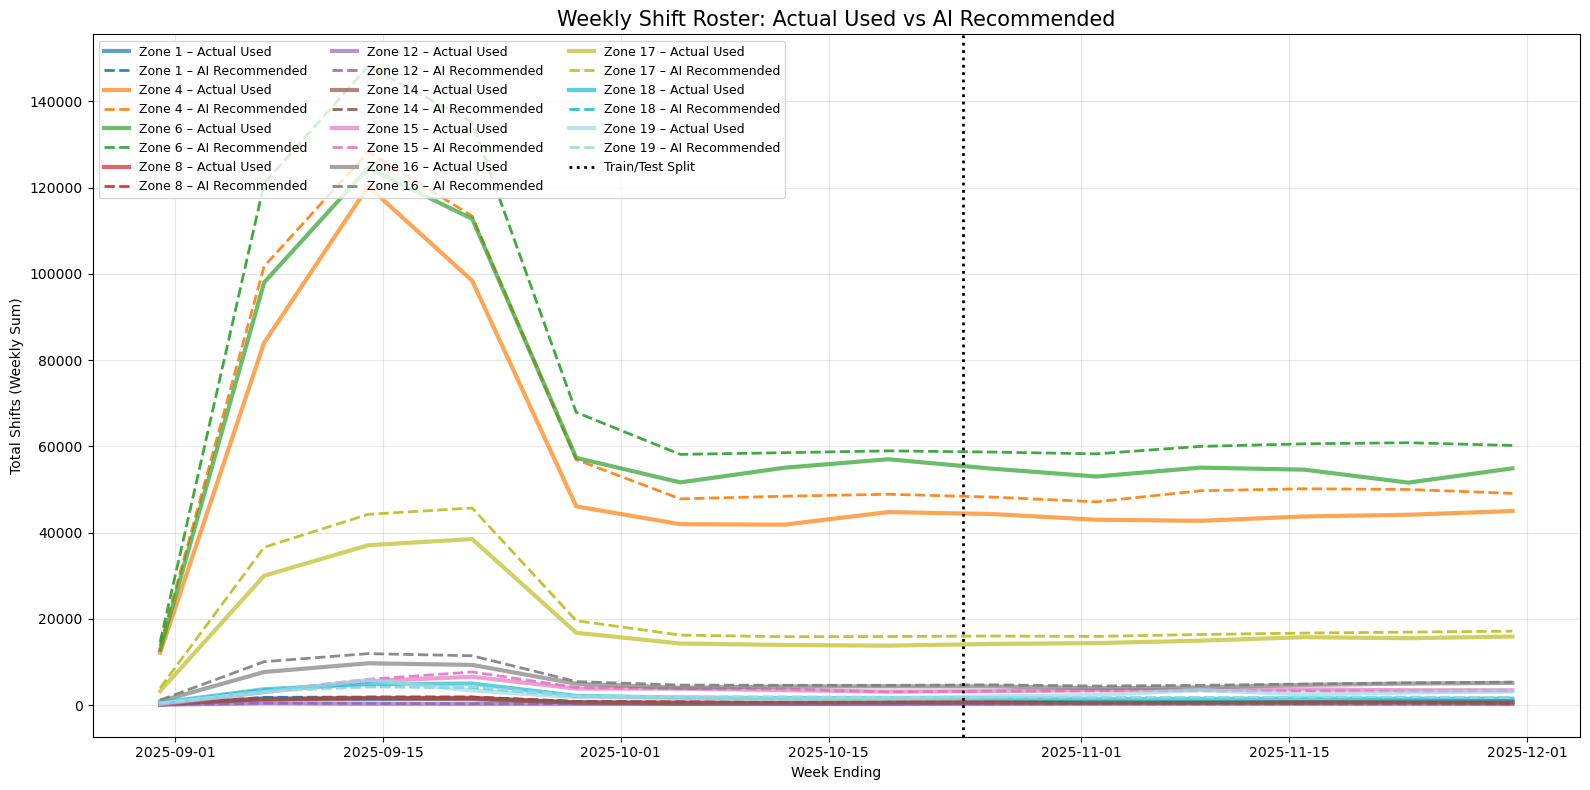

In [64]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -----------------------------
# 1. GENERATE PREDICTIONS (CASCADE)
# -----------------------------
# A. Predict Demand (Orders)
# We predict on the whole df for visualization simplicity
# (In production, you'd respect the train/test split strictly)
df_viz = df.copy()
df_viz['Predicted_Orders'] = model_demand.predict(df_viz[features])

# B. Predict Efficiency (UTR)
# CRITICAL: We must use 'Predicted_Orders' as the input for the UTR model,
# because we wouldn't know the actual orders in a real forecast.
utr_input = df_viz[utr_features].copy()
utr_input['created_orders'] = df_viz['Predicted_Orders'] # <--- The Cascade

df_viz['Predicted_UTR'] = model_utr.predict(utr_input)
df_viz['Predicted_UTR'] = df_viz['Predicted_UTR'].clip(lower=0.3, upper=3.0) # Safety clamp

# C. Calculate Predicted Shifts
# Using the standard formula: Demand / UTR / (1 - Buffer)
buffer = 0.15
df_viz['Predicted_Shifts'] = (df_viz['Predicted_Orders'] / df_viz['Predicted_UTR']) / (1 - buffer)

# -----------------------------
# 2. FILTER DATE RANGE
# -----------------------------
df_viz['order_date'] = pd.to_datetime(df_viz['order_date'])
mask = (df_viz['order_date'] >= '2025-08-31') & (df_viz['order_date'] <= '2025-12-29')
df_viz = df_viz.loc[mask]

# -----------------------------
# 3. WEEKLY AGG BY ZONE
# -----------------------------
# We sum the shifts per week to get the "Total Weekly Roster Size"
weekly_zone_shifts = (
    df_viz
    .set_index('order_date')
    .groupby(['Zone_id', pd.Grouper(freq='W')])[['num_shifts', 'Predicted_Shifts']]
    .sum()
    .reset_index()
)

# -----------------------------
# 4. PLOT
# -----------------------------
plt.figure(figsize=(16, 8))

zones = weekly_zone_shifts['Zone_id'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(zones)))  # distinct colors

for zone, color in zip(zones, colors):
    zone_data = weekly_zone_shifts[weekly_zone_shifts['Zone_id'] == zone]

    # ACTUAL SHIFTS (Solid Line)
    plt.plot(
        zone_data['order_date'],
        zone_data['num_shifts'],
        color=color,
        linewidth=3,
        alpha=0.7,
        label=f'Zone {zone} – Actual Used'
    )

    # PREDICTED SHIFTS (Dashed Line)
    plt.plot(
        zone_data['order_date'],
        zone_data['Predicted_Shifts'],
        color=color,
        linestyle='--',
        linewidth=2,
        alpha=0.9,
        label=f'Zone {zone} – AI Recommended'
    )

# -----------------------------
# 5. TRAIN / TEST SPLIT MARKER
# -----------------------------
# We assume split_point is defined from your training step
if 'split_point' in globals():
    split_date = pd.to_datetime(df.iloc[split_point]['order_date'])
    plt.axvline(split_date, color='black', linestyle=':', linewidth=2, label='Train/Test Split')

# -----------------------------
# 6. FORMATTING
# -----------------------------
plt.title('Weekly Shift Roster: Actual Used vs AI Recommended', fontsize=15)
plt.xlabel('Week Ending')
plt.ylabel('Total Shifts (Weekly Sum)')
plt.grid(alpha=0.3)

# Legend settings
plt.legend(ncol=3, fontsize=9, loc='upper left')
plt.tight_layout()
plt.show()

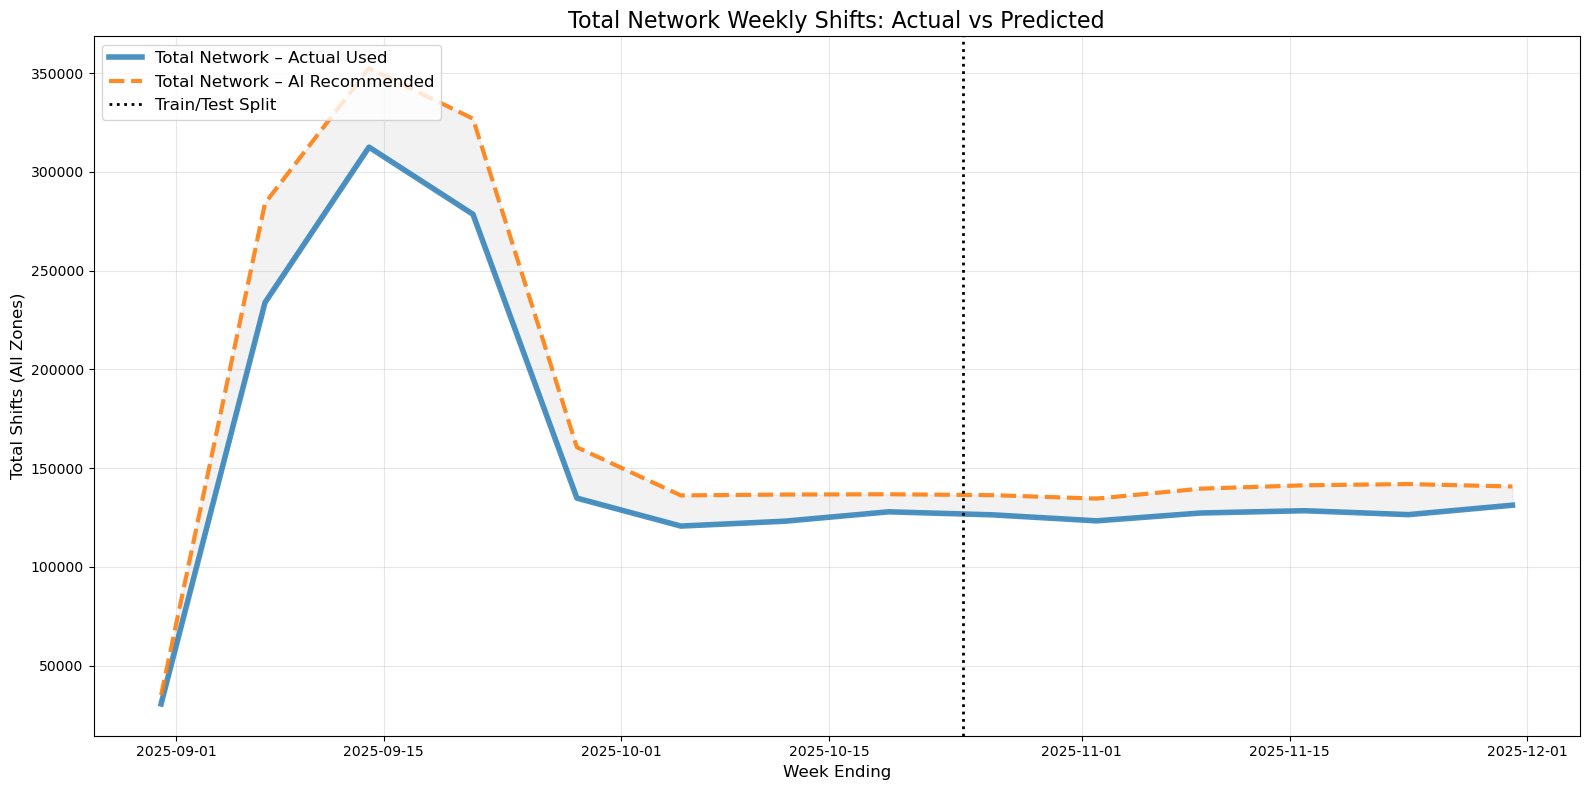

In [65]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# -----------------------------
# 1. GENERATE PREDICTIONS (CASCADE)
# -----------------------------
# A. Predict Demand
df_viz = df.copy()
df_viz['Predicted_Orders'] = model_demand.predict(df_viz[features])

# B. Predict Efficiency (UTR)
# Use PREDICTED demand as input
utr_input = df_viz[utr_features].copy()
utr_input['created_orders'] = df_viz['Predicted_Orders'] 

df_viz['Predicted_UTR'] = model_utr.predict(utr_input)
# Allow UTR to go lower (0.3) so we don't accidentally inflate shift counts
df_viz['Predicted_UTR'] = df_viz['Predicted_UTR'].clip(lower=0.3, upper=3.0) 

# C. Calculate Predicted Shifts
# Standard formula: Demand / UTR / (1 - Buffer)
buffer = 0.15
df_viz['Predicted_Shifts'] = (df_viz['Predicted_Orders'] / df_viz['Predicted_UTR']) / (1 - buffer)

# -----------------------------
# 2. FILTER DATE RANGE
# -----------------------------
df_viz['order_date'] = pd.to_datetime(df_viz['order_date'])
mask = (df_viz['order_date'] >= '2025-08-31') & (df_viz['order_date'] <= '2025-12-29')
df_viz = df_viz.loc[mask]

# -----------------------------
# 3. WEEKLY AGGREGATION (ALL ZONES COMBINED)
# -----------------------------
# CHANGE: Removed 'Zone_id' from groupby to sum everything together
weekly_network_shifts = (
    df_viz
    .set_index('order_date')
    .groupby(pd.Grouper(freq='W'))[['num_shifts', 'Predicted_Shifts']]
    .sum()
    .reset_index()
)

# -----------------------------
# 4. PLOT
# -----------------------------
plt.figure(figsize=(16, 8))

# ACTUAL SHIFTS (Solid Blue Line)
plt.plot(
    weekly_network_shifts['order_date'],
    weekly_network_shifts['num_shifts'],
    color='#1f77b4',  # Standard Blue
    linewidth=4,
    alpha=0.8,
    label='Total Network – Actual Used'
)

# PREDICTED SHIFTS (Dashed Orange Line)
plt.plot(
    weekly_network_shifts['order_date'],
    weekly_network_shifts['Predicted_Shifts'],
    color='#ff7f0e',  # Standard Orange
    linestyle='--',
    linewidth=3,
    alpha=0.9,
    label='Total Network – AI Recommended'
)

# -----------------------------
# 5. TRAIN / TEST SPLIT MARKER
# -----------------------------
if 'split_point' in globals():
    split_date = pd.to_datetime(df.iloc[split_point]['order_date'])
    plt.axvline(split_date, color='black', linestyle=':', linewidth=2, label='Train/Test Split')

# -----------------------------
# 6. FORMATTING
# -----------------------------
plt.title('Total Network Weekly Shifts: Actual vs Predicted', fontsize=16)
plt.xlabel('Week Ending', fontsize=12)
plt.ylabel('Total Shifts (All Zones)', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12, loc='upper left')

# Add a fill between to highlight the difference
plt.fill_between(
    weekly_network_shifts['order_date'],
    weekly_network_shifts['num_shifts'],
    weekly_network_shifts['Predicted_Shifts'],
    color='gray',
    alpha=0.1,
    label='Gap (Efficiency Opportunity)'
)

plt.tight_layout()
plt.show()

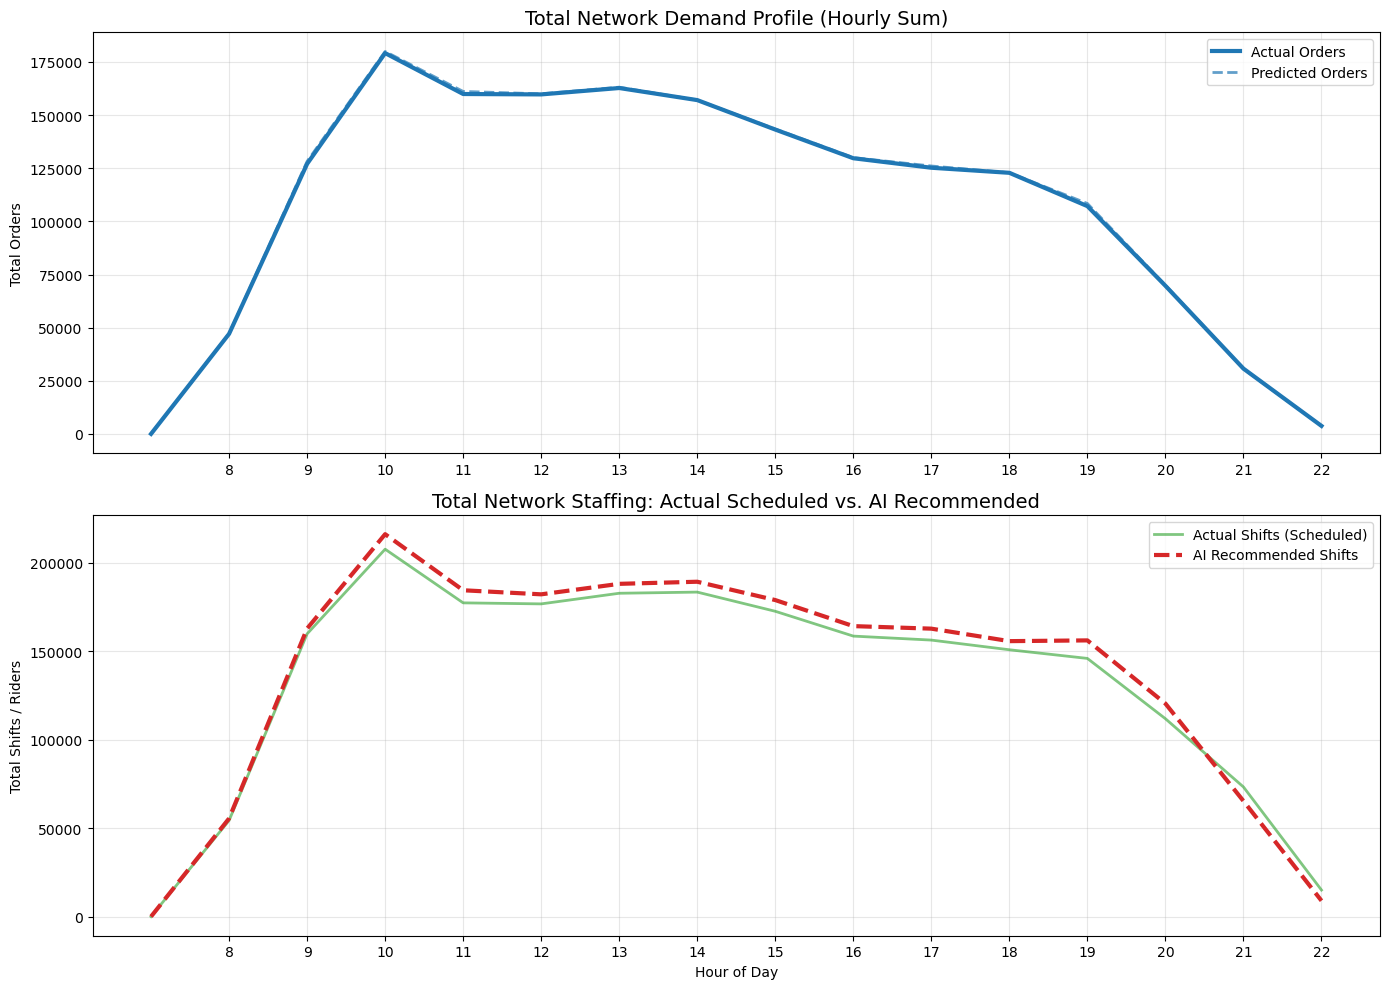


--- AVERAGE NETWORK HOURLY SHIFTS (Daily Avg) ---
 order_hour  num_shifts  Predicted_Shifts
        7.0         0.0               0.2
        8.0       590.1             602.6
        9.0      1735.8            1768.4
       10.0      2255.7            2347.8
       11.0      1926.1            2003.5
       12.0      1919.8            1978.5
       13.0      1985.1            2042.9
       14.0      1992.2            2055.8
       15.0      1874.4            1943.3
       16.0      1722.1            1783.4
       17.0      1697.6            1767.8
       18.0      1638.2            1691.1
       19.0      1585.0            1695.7
       20.0      1214.9            1307.8
       21.0       795.9             709.7
       22.0       163.0              97.5


In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==========================================
# 1. GENERATE PREDICTIONS (FULL DATASET)
# ==========================================
# A. Predict Demand
df_viz = df.copy()
df_viz['Predicted_Orders'] = model_demand.predict(df_viz[features])

# B. Predict Efficiency (UTR)
utr_input = df_viz[utr_features].copy()
utr_input['created_orders'] = df_viz['Predicted_Orders']

df_viz['Predicted_UTR'] = model_utr.predict(utr_input)
df_viz['Predicted_UTR'] = df_viz['Predicted_UTR'].clip(lower=0.1, upper=4.0)

# C. Predict No-Show (Reliability)
df_viz['month'] = df_viz['order_date'].dt.month
df_viz['rain_flag'] = (df_viz.get('rain_orders', 0) > 0).astype(int)

noshow_features_ordered = [
    'hour_sin', 'hour_cos', 
    'dow_sin', 'dow_cos',
    'month', 'rain_flag',   
    'Zone_id_code', 
    'payday_flag', 
    'rolling_4w_same_hour'
]

ns_input = df_viz[noshow_features_ordered]
df_viz['Predicted_NoShow'] = model_noshow.predict(ns_input)
df_viz['Predicted_NoShow'] = df_viz['Predicted_NoShow'].clip(0.05, 0.40)

# D. Calculate Shifts Needed
df_viz['Predicted_Shifts'] = (df_viz['Predicted_Orders'] / df_viz['Predicted_UTR']) / (1 - df_viz['Predicted_NoShow'])

# ==========================================
# 2. FILTER & AGGREGATE BY HOUR
# ==========================================
mask = (df_viz['order_date'] >= '2025-08-31') & (df_viz['order_date'] <= '2025-12-29')
df_viz = df_viz.loc[mask]

# Group by HOUR
hourly_network = df_viz.groupby('order_hour')[
    ['created_orders', 'Predicted_Orders', 'num_shifts', 'Predicted_Shifts']
].sum().reset_index()

# ==========================================
# 3. VISUALIZE NETWORK HOURLY PROFILE
# ==========================================
plt.figure(figsize=(14, 10))

# Chart 1: Demand Profile
plt.subplot(2, 1, 1)
plt.plot(hourly_network['order_hour'], hourly_network['created_orders'], color='#1f77b4', linewidth=3, label='Actual Orders')
plt.plot(hourly_network['order_hour'], hourly_network['Predicted_Orders'], color='#1f77b4', linestyle='--', linewidth=2, alpha=0.7, label='Predicted Orders')
plt.title('Total Network Demand Profile (Hourly Sum)', fontsize=14)
plt.ylabel('Total Orders')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(8, 23))

# Chart 2: Staffing Profile (Cleaned)
plt.subplot(2, 1, 2)

# Line A: Actual Shifts Used (Scheduled)
plt.plot(hourly_network['order_hour'], hourly_network['num_shifts'], 
         color='#2ca02c', linewidth=2, alpha=0.6, label='Actual Shifts (Scheduled)')

# Line B: AI Recommended (Target)
plt.plot(hourly_network['order_hour'], hourly_network['Predicted_Shifts'], 
         color='#d62728', linestyle='--', linewidth=3, label='AI Recommended Shifts')

plt.title('Total Network Staffing: Actual Scheduled vs. AI Recommended', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Total Shifts / Riders')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(range(8, 23))

plt.tight_layout()
plt.show()

# ==========================================
# 4. PRINT SUMMARY TABLE
# ==========================================
hourly_avg = hourly_network.copy()
# Normalize to daily average
hourly_avg[['created_orders', 'Predicted_Orders', 'num_shifts', 'Predicted_Shifts']] /= df_viz['order_date'].nunique()

print("\n--- AVERAGE NETWORK HOURLY SHIFTS (Daily Avg) ---")
print(hourly_avg[['order_hour', 'num_shifts', 'Predicted_Shifts']].round(1).to_string(index=False))

In [78]:
import xgboost as xgb
import pickle
import os

print("Saving models to disk...")

# 1. Save the XGBoost Models (as lightweight JSON files)
# .json is better than .model because it's human-readable and cross-compatible
model_demand.save_model("model_demand_v1.json")
model_utr.save_model("model_utr_v1.json")
model_noshow.save_model("model_noshow_v1.json")

# 2. Save the Zone Mapping Dictionary
# We use pickle because this is a Python dictionary, not a model
with open("zone_mapping_v1.pkl", "wb") as f:
    pickle.dump(zone_mapping, f)

print("\n✅ Success! The following files have been created in your folder:")
print(os.listdir('.')) # Lists files to confirm they exist

Saving models to disk...

✅ Success! The following files have been created in your folder:
['.anaconda', '.conda', '.continuum', '.ipynb_checkpoints', '.ipython', '.jupyter', '.matplotlib', '.python_history', 'anaconda3', 'AppData', 'Application Data', 'Contacts', 'Cookies', 'Desktop', 'Documents', 'Downloads', 'Favorites', 'Forcasting_Model.ipynb', 'IntelGraphicsProfiles', 'Links', 'Local Settings', 'model_demand_v1.json', 'model_noshow_v1.json', 'model_utr_v1.json', 'Music', 'My Documents', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{6c1fd604-04d8-11ef-b135-88a4c2f80755}.TM.blf', 'NTUSER.DAT{6c1fd604-04d8-11ef-b135-88a4c2f80755}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{6c1fd604-04d8-11ef-b135-88a4c2f80755}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'Pictures', 'PrintHood', 'Recent', 'Saved Games', 'Searches', 'SendTo', 'Start Menu', 'Templates', 'Untitled.ipynb', 'Untitled1.ipynb', 'Untitled2.ipynb', 'Untitl